# Usermore soap case study

Guilherme Fernandes e Lauro Solia

In [71]:
from pprint import pprint

import gurobipy
from gurobipy import Model, GRB
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## 1. Defining the sets

In [72]:
plants = [
    "Covington",
    "New York",
    "Arlington",
    "Long Beach",
]

existing_warehouses = [
    "Atlanta",
    "Boston",
    "Buffalo",
    "Chicago",
    "Cleveland",
    "Davenport",
    "Detroit",
    "Grand Rapids",
    "Greensboro",
    "Kansas City",
    "Baltimore",
    "Memphis",
    "Milwaukee",
    "Orlando",
    "Pittsburgh",
    "Portland",
    "W Sacramento",
    "W Chester",
]

potential_warehouses = [
    "Albuquerque",
    "Billings",
    "Denver",
    "El Paso",
    "Camp Hill",
    "Houston",
    "Las Vegas",
    "Minneapolis",
    "New Orleans",
    "Phoenix",
    "Richmond",
    "St Louis",
    "Salt Lake City",
    "San Antonio",
    "Seattle",
    "Spokane",
    "San Francisco",
    "Indianapolis",
    "Louisville",
    "Columbus",
    "New York-",
    "Hartford",
    "Miami",
    "Mobile",
    "Memphis *",
    "Chicago *",
]

warehouses = plants + existing_warehouses

In [73]:
print("Number of plants: ", len(plants))
print("Number of existing warehouses: ", len(existing_warehouses))
print("Number of potential warehouses: ", len(potential_warehouses))
print("Number of total available warehouses for this case: ", len(warehouses))
print("Obs.: Each plant is also an existing warehouse")

Number of plants:  4
Number of existing warehouses:  18
Number of potential warehouses:  26
Number of total available warehouses for this case:  22
Obs.: Each plant is also an existing warehouse


## 2. Parameters

### Service Level

In [74]:
# 93% under 1_500_000 miles
SERVICE_LEVEL_DISTANCE = 600
# SERVICE_LEVEL = 0.93

### Demand

In [75]:
# read state demands from Figure 1
state_demand = {
    # West region:
    "WA": 32437,  # Washington
    "OR": 31365,  # Oregon
    "CA": 135_116,  # California
    "NV": 16755,  # Nevada
    "AZ": 9063,  # Arizona
    "ID": 7153,  # Idaho
    # Northwest region:
    "UT": 9001,  # Utah
    "MT": 4140,  # Montana
    "ND": 5703,  # North Dakota
    "WY": 1004,  # Wyoming
    "CO": 11147,  # Colorado
    "SD": 1049,  # South Dakota
    "NE": 7347,  # Nebraska
    "KS": 6961,  # Kansas
    "MN": 5633,  # Minnesota
    "IA": 32175,  # Iowa
    "MO": 41680,  # Missouri
    # Southwest region:
    "NM": 3536,  # New Mexico
    "TX": 80438,  # Texas
    "OK": 13517,  # Oklahoma
    "AR": 4910,  # Arkansas
    "LA": 15011,  # Louisiana
    # Midwest region:
    "WI": 37448,  # Wisconsin
    "IL": 72839,  # Illinois
    "MI": 105_181,  # Michigan
    "IN": 43994,  # Indiana
    "KY": 3870,  # Kentucky
    "OH": 155_123,  # Ohio
    # Northeast region:
    "ME": 15829,  # Maine
    "NH": 4546,  # New Hampshire
    "RI": 17000,  # Rhode Island
    "NJ": 21154,  # New Jersey
    "NY": 160_917,  # New York
    "PA": 65108,  # Pennsylvania
    "CT": 26_187,  # Connecticut
    "MA": 37087,  # Massachusetts
    "VA": 17667,  # Virginia
    "WV": 9168,  # West Virginia
    "MD": 19_284,  # Maryland
    "VT": 2_928,  # Vermont
    "DE": 3_044,  # Delaware
    # Southeast region:
    "TN": 42_479,  # Tennessee
    "MS": 15_205,  # Mississippi
    "AL": 15_835,  # Alabama
    "GA": 29_559,  # Georgia
    "FL": 46_405,  # Florida
    "SC": 5_680,  # South Carolina
    "NC": 28_348,  # North Carolina
}

In [76]:
S = state_demand  # Sales
total_demand = sum(S.values())

print("Total states number: ", len(S))
print("Total demand: ", total_demand)
print("Each state represents a demand center")

# NOTE: Valor total deve ser 1_477_026, então precisei ajustar NY (que nao tem na foto) pra bater o valor final.

Total states number:  48
Total demand:  1477026
Each state represents a demand center


In [77]:
demand_centers = [f"{s}" for s in state_demand.keys()]

# pprint(demand_centers)

### Capacities

In [78]:
# Plants current capacities C[p]
C = {
    "Covington": 620_000,
    "New York": 430_000,
    "Arlington": 300_000,
    "Long Beach": 280_000,
}

In [79]:
# Warehouse/Plant stocking capacities C'[p]
# (plants have capacity to stock, but the public warehouses do not)
C_prime = {
    "Covington": 450_000,
    "New York": 380_000,
    "Arlington": 140_000,
    "Long Beach": 180_000,
}

### Distances

In [80]:
# Distance matrices (in miles)
#     d_pw[p][w] = distance plant → warehouse
#     d_wd[w][d] = distance warehouse → demand center

df_pw = pd.read_excel(
    "../distances/distance_matrix.xlsx", sheet_name="d_pw", index_col=0
)
df_wd = pd.read_excel(
    "../distances/distance_matrix.xlsx", sheet_name="d_ws", index_col=0
)

d_pw = df_pw.to_dict()
d_wd = df_wd.to_dict()

In [81]:
# print("Distance matrices:")
# print("d_pw (plant to warehouse):")
# pprint(d_pw)
# print("d_wd (warehouse to demand center):")
# pprint(d_wd)


### Costs

In [82]:
# Unit production cost (variable production cost)
rho = {
    "Covington": 21.0,
    "New York": 19.9,
    "Arlington": 21.6,
    "Long Beach": 21.1,
}

In [83]:
# Inbound cost c_in[p][w] = 0.92 + 0.0034*d_pw
# Represents costs from plants to warehouses
c_in = {
    p: {w: 0.92 + 0.0034 * d_pw[p][w.replace("-", "")] for w in warehouses}
    for p in plants
}

# c_in

In [84]:
# Ler tabela 3 do excel
table3 = pd.read_excel("../misc/tabelas.xlsx", sheet_name="table3")

table3.head()

,Warehouse No.,Storage ($/$),Handling ($/cwt),Stock Order Processing ($/order),Stock Order Size,Customer Order Processing ($/order),Customer Order size (cwt/order),Local delivery rate ($/cwt)
0,1,0.0672,0.46,18,400,1.79,9.05,1.90
1,2,0.0567,0.54,18,400,1.74,10.92,3.89
2,3,0.0755,0.38,18,400,2.71,11.59,2.02
3,4,0.0735,0.59,18,400,1.74,11.30,4.31
4,5,0.0946,0.50,18,401,0.83,9.31,1.89


In [85]:
# NOTE: usamos esse código so pra checar se existem valores abaixo de 30 milhas
# for k, v in d_ws.items():
#     for k2, v2 in v.items():
#         if v2 <= 30:
#             print(k, k2, v2)

In [86]:
# Outbound cost c_out[w][j]:
# Custo de enviar do warehouse para o demand center

local_rate = {i: v for i, v in enumerate(table3["Local delivery rate ($/cwt)"])}

c_out = {}
for i, w in enumerate(warehouses):
    # w = w.replace("-", "")
    c_out[w] = {}
    for s in demand_centers:
        d = d_wd[w][s]
        if d <= 30:
            # if d<=30: use local cartage rate from Table 3
            c_out[w][s] = local_rate[i]
        else:
            # else use 5.45 + 0.0037*d
            c_out[w][s] = 5.45 + 0.0037 * d

# c_out

In [87]:
# Conversão de unidades:
# Quanto representa 1 cwt. em $?
# Dividimos as vendas totais ($) pela demand total (cwt)
Gamma = 160_000_000 / 1_477_026  # ($ / cwt)
Gamma

108.32578438023434

In [88]:
# Custo de estocagem do armazém w (Storage rate)
tau = {}

for i, w in enumerate(warehouses):
    # Fiz o casting para evitar o np.float64 nos prints, mas nao precisava
    tau[w] = float(table3["Storage ($/$)"][i])

In [89]:
# Custo de handling do armazém w (epsilon)

epsilons = {}

for i, w in enumerate(warehouses):
    epsilons[w] = float(table3["Handling ($/cwt)"][i])

In [90]:
# gamma

gammas = {}

for i, w in enumerate(warehouses):
    gammas[w] = float(table3["Stock Order Processing ($/order)"][i])

In [91]:
# delta

deltas = {}

for i, w in enumerate(warehouses):
    deltas[w] = float(table3["Stock Order Size"][i])

In [92]:
# omega

omegas = {}

for i, w in enumerate(warehouses):
    omegas[w] = float(table3["Customer Order size (cwt/order)"][i])

In [93]:
# phi

phi = {}
for i, w in enumerate(warehouses):
    phi[w] = float(table3["Customer Order Processing ($/order)"][i])

## 3. Defining the model

In [94]:
m = Model(name="UsemoreWarehousing")

### Indices

In [95]:
print(plants)
print(warehouses)
# NOTE: tem que ver se o "New York-" não vai dar bug quando permitirmos os potentials
print(demand_centers)

['Covington', 'New York', 'Arlington', 'Long Beach']
['Covington', 'New York', 'Arlington', 'Long Beach', 'Atlanta', 'Boston', 'Buffalo', 'Chicago', 'Cleveland', 'Davenport', 'Detroit', 'Grand Rapids', 'Greensboro', 'Kansas City', 'Baltimore', 'Memphis', 'Milwaukee', 'Orlando', 'Pittsburgh', 'Portland', 'W Sacramento', 'W Chester']
['WA', 'OR', 'CA', 'NV', 'AZ', 'ID', 'UT', 'MT', 'ND', 'WY', 'CO', 'SD', 'NE', 'KS', 'MN', 'IA', 'MO', 'NM', 'TX', 'OK', 'AR', 'LA', 'WI', 'IL', 'MI', 'IN', 'KY', 'OH', 'ME', 'NH', 'RI', 'NJ', 'NY', 'PA', 'CT', 'MA', 'VA', 'WV', 'MD', 'VT', 'DE', 'TN', 'MS', 'AL', 'GA', 'FL', 'SC', 'NC']


### Decision variables

In [96]:
# Se eu uso um armazém: Z[w] = 1
Z = m.addVars(warehouses, vtype=GRB.BINARY, name="z")

# Quanto de volume mando de p para w
X = m.addVars(plants, warehouses, vtype=GRB.CONTINUOUS, name="x")

# Quanto de volume mando de w para d
Y = m.addVars(warehouses, demand_centers, vtype=GRB.CONTINUOUS, name="y")

## 4. Objective Function

### Define all the costs components

In [97]:
# inbound transport (from plants to warehouses)
# NOTE: coloquei esse if w != p porque nao ha custo de transporte para levar da planta para o seu próprio armazém
inbound_transport_cost = gurobipy.quicksum(
    c_in[p][w] * X[p, w] for p in plants for w in warehouses if w != p
)

In [98]:
# outbound transport (from warehouses to demand nodes)
outbound_transport_cost = gurobipy.quicksum(
    c_out[w][d] * Y[w, d] for w in warehouses for d in demand_centers
)

In [99]:
# production cost
production_costs = gurobipy.quicksum(
    rho[p] * (X[p, w]) for p in plants for w in warehouses
)

In [100]:
# Storage cost in warehouses
# Para cada armazém, calcula o custo de estocagem individualmente e soma todos

m.Params.NonConvex = 2

storage_pow = {}
storage_costs = []

for w in warehouses:
    # total de saída do armazém w
    totX_w = m.addVar(name=f"totX_{w}")

    m.addConstr(
        totX_w == gurobipy.quicksum(Y[w, d] for d in demand_centers),
        name=f"define_totX_{w}",
    )

    # variável para totX_w^0.58
    storage_pow[w] = m.addVar(name=f"storage_pow_{w}")

    m.addGenConstrPow(totX_w, storage_pow[w], 0.58, name=f"storage_pow_{w}")

    # custo de estocagem para o armazém w
    storage_costs.append(26 * 11.3 * storage_pow[w])

# soma total dos custos de estocagem
storage_costs = gurobipy.quicksum(storage_costs)

Set parameter NonConvex to value 2


In [101]:
# INVENTORY
inventory_pow = {}
inventory_costs = []

for w in warehouses:
    # total de saída do armazém w
    totX_w = m.addVar(name=f"totX_{w}")

    m.addConstr(
        totX_w == gurobipy.quicksum(Y[w, d] for d in demand_centers),
        name=f"define_totX_{w}",
    )

    # variável para totX_w^0.58
    inventory_pow[w] = m.addVar(name=f"inventory_pow_{w}")

    m.addGenConstrPow(totX_w, inventory_pow[w], 0.58, name=f"inventory_pow_{w}")

    # custo de Inventory para o armazém w
    inventory_costs.append(26 * 0.12 * 11.3 * inventory_pow[w])

# soma total dos custos de estocagem
inventory_costs = gurobipy.quicksum(inventory_costs)

In [102]:
# custo de handling nos armazéns
handling_costs = gurobipy.quicksum(
    2 * Z[w] * X[p, w] * epsilons[w] for p in plants for w in warehouses
)

In [103]:
# custo de processamento do pedido de estoque
stock_order_processing_costs = gurobipy.quicksum(
    Z[w] * X[p, w] * (gammas[w] / deltas[w]) for p in plants for w in warehouses
)

In [104]:
# custo de processamento do pedido do cliente
customer_order_processing_costs = gurobipy.quicksum(
    Z[w] * Y[w, d] * (phi[w] / omegas[w]) for w in warehouses for d in demand_centers
)

### Define the objective function

In [105]:
m.setObjective(
    inbound_transport_cost
    + outbound_transport_cost
    + production_costs
    + storage_costs
    + inventory_costs
    + handling_costs
    + stock_order_processing_costs
    + customer_order_processing_costs,
    sense=GRB.MINIMIZE,
)

## Constraints

### Service level

In [106]:
# Porcentagem de volume atendidos a uma distância menor que SERVICE_LEVEL_DISTANCE milhas

service_level_30 = gurobipy.quicksum(
    Y[w, d] / total_demand
    for w in warehouses
    for d in demand_centers
    if d_wd[w][d] <= 30
)
service_level_100 = gurobipy.quicksum(
    Y[w, d] / total_demand
    for w in warehouses
    for d in demand_centers
    if d_wd[w][d] <= 100
)
service_level_300 = gurobipy.quicksum(
    Y[w, d] / total_demand
    for w in warehouses
    for d in demand_centers
    if d_wd[w][d] <= 300
)
service_level_600 = gurobipy.quicksum(
    Y[w, d] / total_demand
    for w in warehouses
    for d in demand_centers
    if d_wd[w][d] <= 600
)
service_level_1000 = gurobipy.quicksum(
    Y[w, d] / total_demand
    for w in warehouses
    for d in demand_centers
    if d_wd[w][d] <= 1000
)
service_level_1500 = gurobipy.quicksum(
    Y[w, d] / total_demand
    for w in warehouses
    for d in demand_centers
    if d_wd[w][d] <= 1500
)


# m.addConstr(
#     service_level >= SERVICE_LEVEL,
#     name="service_level",
# )

In [107]:
# Distancias medianas de um armazém para os centros de demanda

# for w in d_wd.keys():
#     q1 = np.percentile(list(d_wd[w].values()), 95)
#       print(f"{w:>20} {q1:>7.2f}")

### Demand

In [108]:
# Demand satisfaction

for d in demand_centers:
    m.addConstr(
        gurobipy.quicksum(Y[w, d] for w in warehouses) == S[d],
        name=f"demand_{d}",
    )

### Production

In [109]:
# Plant production capacity

for p in plants:
    m.addConstr(
        gurobipy.quicksum(X[p, w] for w in warehouses) <= C[p],
        name=f"plantCap_{p}",
    )

### Capacity

In [110]:
# restrição dos 10400

for w in warehouses:
    # Um armazém só pode ser aberto se houver demanda de pelo menos 10_400 cwt
    m.addConstr(
        gurobipy.quicksum(Y[w, d] for d in demand_centers) >= 10_400 * Z[w],
        name=f"minThroughput_{w}",
    )

In [111]:
# restrições de armazenagem de cada planta

for p1 in plants:
    m.addConstr(
        gurobipy.quicksum(X[p2, p1] for p2 in plants) <= C_prime[p1],
        name=f"plantStorageCap_{p1}",
    )

### Flow balance

In [112]:
# Flow balance at each warehouse (está quebrando o código...)

for w in warehouses:
    # Tudo que entra no armazém deve ser igual a tudo que sai
    m.addConstr(
        gurobipy.quicksum(X[p, w] for p in plants)
        == gurobipy.quicksum(Y[w, d] for d in demand_centers),
        name=f"flowBalance_{w}",
    )

### Flow conservation

In [113]:
M = total_demand

In [114]:
# Restrições de Z (só posso usar um armazém se ele estiver aberto)
for w in warehouses:
    for p in plants:
        # NOTE: the C[p] here is working as the big-M
        m.addConstr(
            X[p, w] <= M * Z[w],
            name=f"openWarehouse_{w},{p}",
        )
    for d in demand_centers:
        # NOTE: the S[d] here is working as the big-M
        m.addConstr(
            Y[w, d] <= M * Z[w],
            name=f"openWarehouse_{w},{d}",
        )

## Solver

In [115]:
# NOTE: precisou ser o formato .rlp pois algumas variáveis têm espaço
m.write("model-baseline.rlp")
# m.write("model-baseline.lp")

In [116]:
m.params.TimeLimit = 600  # seconds

Set parameter TimeLimit to value 600


In [117]:
m.presolve()

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: AMD Ryzen 7 7730U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Presolve added 106 rows and 3322 columns
Presolve time: 0.06s


<gurobi.Model MIP instance UsemoreWarehousing_pre: 2538 constrs, 5720 vars, Parameter changes: TimeLimit=600.0, Username=(user-defined), NonConvex=2>

In [118]:
m.optimize()

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: AMD Ryzen 7 7730U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 1288 rows, 1254 columns and 7826 nonzeros
Model fingerprint: 0xe976db95
Model has 1144 quadratic objective terms
Model has 44 general constraints
Variable types: 1232 continuous, 22 integer (22 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  Objective range  [2e+00, 3e+02]
  QObjective range [2e-01, 7e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+03, 6e+05]
Presolve added 106 rows and 3322 columns
Presolve time: 0.05s
Presolved: 2538 rows, 5720 columns, 18128 nonzeros
Presolved model has 44 SOS constraint(s)
Variable types: 5698 continuous, 22 integer (22 binary)

Root relaxation: objective 4.417745e+07, 510 iterations, 0.02 seconds (0.01 work units)

    Nodes    |    Current Node    | 

In [119]:
m.printStats()


Statistics for model UsemoreWarehousing:
  Linear constraint matrix    : 1288 Constrs, 1254 Vars, 7826 NZs
  Variable types              : 1232 Continuous,
22 Integer (22 Binary)
  General constraints         : 44 Constrs
  Matrix coefficient range    : [ 1, 1.47703e+06 ]
  Objective coefficient range : [ 1.73, 293.8 ]
  Variable bound range        : [ 1, 1 ]
  RHS coefficient range       : [ 1004, 620000 ]


In [120]:
m.printQuality()


Solution quality statistics for model UsemoreWarehousing :
  Maximum violation:
    Bound       : 0.00000000e+00
    Constraint  : 1.81663197e+00 (inventory_pow_Covington)
    Integrality : 0.00000000e+00


## Visualize results

### Costs

In [121]:
# Print the solution objective value
print(f"Objective function final value: ${m.objVal:,.2f}")

Objective function final value: $45,501,758.00


In [122]:
def display_cost_components():
    """Calculate and display all cost components"""

    # Get cost values from the model
    costs = {
        "Inbound transport cost": inbound_transport_cost.getValue(),
        "Outbound transport cost": outbound_transport_cost.getValue(),
        "Production costs": production_costs.getValue(),
        "Storage costs": storage_costs.getValue(),
        "Handling costs": handling_costs.getValue(),
        "Stock order processing costs": stock_order_processing_costs.getValue(),
        "Customer order processing costs": customer_order_processing_costs.getValue(),
        "Inventory Carrying Costs": inventory_costs.getValue(),
    }

    # Calculate total cost
    total = sum(costs.values())

    # Print the cost components in a formatted table
    print("\n" + "=" * 65)
    print(f"{'COST BREAKDOWN':^65}")
    print("=" * 65)
    print(f"{'Cost Component':<30} {'Amount ($)':>18} {'Percentage':>12}")
    print("-" * 65)

    try:
        for name, value in costs.items():
            percentage = (value / total) * 100
            print(f"{name:<32} ${value:>17,.2f} {percentage:>11.2f}%")
    except ZeroDivisionError:
        pass

    print("-" * 65)
    print(f"{'TOTAL COST':<32} ${total:>17,.2f} {100:>11.2f}%")
    print("=" * 65)


# Call the function to display costs
display_cost_components()


                         COST BREAKDOWN                          
Cost Component                         Amount ($)   Percentage
-----------------------------------------------------------------
Inbound transport cost           $       945,970.51        2.08%
Outbound transport cost          $     9,363,451.41       20.58%
Production costs                 $    30,675,786.60       67.42%
Storage costs                    $     2,376,084.73        5.22%
Handling costs                   $     1,544,196.00        3.39%
Stock order processing costs     $        65,727.45        0.14%
Customer order processing costs  $       245,411.14        0.54%
Inventory Carrying Costs         $       285,130.17        0.63%
-----------------------------------------------------------------
TOTAL COST                       $    45,501,758.00      100.00%


### Locations

In [123]:
open_w = [w for w in warehouses if Z[w].X > 0.1]
closed_w = [w for w in warehouses if Z[w].X < 0.1]

print(f"Number of open warehouses 🏭: {len(open_w)} ")
print(f"Number of closed warehouses 🔒: {len(closed_w)} ")

# Calculate percentage of open warehouses
percentage_open = (len(open_w) / len(warehouses)) * 100
print(f"Percentage of warehouses open: {percentage_open:.1f}% 📊")


print("\n------------------ Warehouse openings ------------------")
for w in open_w:
    volume = X.sum("*", w).getValue()
    print(f" Open warehouse at {w:>15} ({volume:>9.2f} cwt)")

if len(closed_w) > 0:
    print("\n------------------ Warehouse closings ------------------")
    for w in closed_w:
        volume = X.sum("*", w).getValue()
        print(f" Closed warehouse at {w:>13} ({volume:>9.2f} cwt)")

Number of open warehouses 🏭: 7 
Number of closed warehouses 🔒: 15 
Percentage of warehouses open: 31.8% 📊

------------------ Warehouse openings ------------------
 Open warehouse at       Covington (450000.00 cwt)
 Open warehouse at        New York (380000.00 cwt)
 Open warehouse at       Arlington (140000.00 cwt)
 Open warehouse at      Long Beach (180000.00 cwt)
 Open warehouse at         Atlanta (207076.00 cwt)
 Open warehouse at       Baltimore ( 50000.00 cwt)
 Open warehouse at        Portland ( 69950.00 cwt)

------------------ Warehouse closings ------------------
 Closed warehouse at        Boston (     0.00 cwt)
 Closed warehouse at       Buffalo (     0.00 cwt)
 Closed warehouse at       Chicago (     0.00 cwt)
 Closed warehouse at     Cleveland (     0.00 cwt)
 Closed warehouse at     Davenport (     0.00 cwt)
 Closed warehouse at       Detroit (     0.00 cwt)
 Closed warehouse at  Grand Rapids (     0.00 cwt)
 Closed warehouse at    Greensboro (     0.00 cwt)
 Closed wareh

### Service level results

In [124]:
# Calculate and print cumulative service level curve

service_levels = [
    (30, service_level_30.getValue()),
    (100, service_level_100.getValue()),
    (300, service_level_300.getValue()),
    (600, service_level_600.getValue()),
    (1000, service_level_1000.getValue()),
    (1500, service_level_1500.getValue()),
]

print("=" * 60)
print(f"{'Service Level Curve':^60}")
print("=" * 60)
print(f"{'Distance (miles)':<20} {'Service Level (%)':>35}")
print("-" * 60)
for dist, level in service_levels:
    print(f"{dist:>20} {100 * level:25.2f}")
# print("-" * 60)

                    Service Level Curve                     
Distance (miles)                       Service Level (%)
------------------------------------------------------------
                  30                      1.31
                 100                     19.53
                 300                     65.91
                 600                     92.73
                1000                     99.55
                1500                    100.00


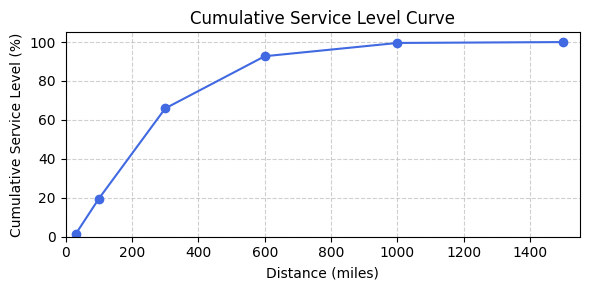

In [125]:
# Optionally, plot the cumulative curve if matplotlib is available


distances = [d for d, _ in service_levels]
levels = [100 * sl for _, sl in service_levels]

plt.figure(figsize=(6, 3))
plt.plot(distances, levels, marker="o", linestyle="-", color="royalblue")
plt.title("Cumulative Service Level Curve")
plt.xlabel("Distance (miles)")
plt.ylabel("Cumulative Service Level (%)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.ylim(0, 105)
plt.xlim(0, max(distances) + 50)
plt.tight_layout()
plt.show()

In [126]:
# TODO: Salvar os open warehouses em um arquivo


### Production

In [127]:
plant_production = {}

for p in plants:
    plant_production[p] = sum(X[p, w].X for w in warehouses if Z[w].X > 0.1)

print("\n------------------ Plant production ----------------------")
total_production = sum(plant_production.values())
for p in plants:
    percentage = (plant_production[p] / total_production) * 100
    print(
        f" Plant {p:>15} production: {plant_production[p]:,.2f} cwt ({percentage:>4.1f}%)"
    )
print("----------------------------------------------------------")
print(f"Total production: {total_production:,.2f} cwt")


------------------ Plant production ----------------------
 Plant       Covington production: 620,000.00 cwt (42.0%)
 Plant        New York production: 430,000.00 cwt (29.1%)
 Plant       Arlington production: 177,076.00 cwt (12.0%)
 Plant      Long Beach production: 249,950.00 cwt (16.9%)
----------------------------------------------------------
Total production: 1,477,026.00 cwt


### Flows

In [128]:
print("\n---------- Plant → Warehouse flows -------------")
for p, w in X.keys():
    if X[p, w].X > 1e-6:
        print(f" {p:>15} → {w:<15} = {X[p, w].X:>6.0f} cwt")


---------- Plant → Warehouse flows -------------
       Covington → Covington       = 450000 cwt
       Covington → Atlanta         = 170000 cwt
        New York → New York        = 380000 cwt
        New York → Baltimore       =  50000 cwt
       Arlington → Arlington       = 140000 cwt
       Arlington → Atlanta         =  37076 cwt
      Long Beach → Long Beach      = 180000 cwt
      Long Beach → Portland        =  69950 cwt


In [129]:
print("\n------- Warehouse → Demand flows ---")
for w, j in Y.keys():
    if Y[w, j].X > 1e-6:
        print(f" {w:>16} → {j}: {Y[w, j].X:>6.0f} cwt")


------- Warehouse → Demand flows ---
        Covington → ND:   5703 cwt
        Covington → MN:   5633 cwt
        Covington → IA:  32175 cwt
        Covington → MO:  14234 cwt
        Covington → WI:  37448 cwt
        Covington → IL:  72839 cwt
        Covington → MI:  78981 cwt
        Covington → IN:  43994 cwt
        Covington → KY:   3870 cwt
        Covington → OH: 155123 cwt
         New York → MI:  26200 cwt
         New York → ME:  15829 cwt
         New York → NH:   4546 cwt
         New York → RI:  17000 cwt
         New York → NJ:  21154 cwt
         New York → NY: 160917 cwt
         New York → PA:  65108 cwt
         New York → CT:  26187 cwt
         New York → MA:  37087 cwt
         New York → VT:   2928 cwt
         New York → DE:   3044 cwt
        Arlington → CO:  10767 cwt
        Arlington → SD:   1049 cwt
        Arlington → NE:   7347 cwt
        Arlington → KS:   6961 cwt
        Arlington → TX:  80438 cwt
        Arlington → OK:  13517 cwt
        Arlington